 - Artist: 
type (person, group, orchestra), begin place , end place, begin date, end date, identifier, external identifier(dbpedia, musicbrainz, otras fuentes), name, gender, alias (variaciones del nombre), related artists (cada relación con un tipo: Colaborador, tocaron juntos, hicieron giras)

 - Work (composicion)
title, identifier, external identifier, composer, lyricist, date, place, lyric? score?

 - Recording (grabación de una canción, por ejemplo una grabación en vivo de una canción es un recording distinto de una grabación en estudio de la misma canción): duration, work, performers(cada uno con un instrumento asociado), identifier, external identifiers, duration, title, audio(link externo: spotify, soundcloud, etc. Link interno?), video(link externos youtube, etc), 

 - Release (album)
title, date, primary artist, identifier, external identifier, list of recordings

 - Genres or Epochs
Esta información tal vez puede ser extraída de las diferentes fuentes de información.
Artistas relacionados, epoca?

In [1]:
import json
import requests
from collections import Counter

artists = json.load(open("data/artists.json"))
works = json.load(open("data/works.json"))

Load in artists_new cleaned artists with new id generated.

In [2]:
month = {'enero':1,'febrero':2,'marzo':3, 'abril':4, 'mayo':5, 'junio':6, 'julio':7, 'agosto':8, 'septiembre':9, 'octubre':10, 'noviembre':11, 'diciembre':12}
categories = {u'Carteto T\xedpico': 'Group',
        u'Conjunto': 'Group',
        u'Conjunto coral': 'Group',
        u'Conjunto de guitarras': 'Group',
        u'Cuarteto': 'Group',
        u'Cuarteto T\xedpico': 'Group',
        u'Cuarteto de tango': 'Group',
        u'D\xfao de guitarras': 'Group',
        u'D\xfao de piano ': 'Group',
        u'D\xfao de tango': 'Group',
        u'M\xfasicos': 'Group',
        u'Orquesta': 'Orchestra',
        u'Orquesta T\xedpica': 'Orchestra',
        u'Orquesta de cuerdas tensadas ': 'Orchestra',
        u'Quinteto': 'Group',
        u'Quinteto T\xedpico': 'Group',
        u'Tr\xedo': 'Group',
        u'Tr\xedo de guitarras ': 'Group',
        u'Tr\xedo de viol\xedn': 'Group',
        u'Tr\xedo vocal': 'Group'
    }
artist_map = {}
artist_map['http://www.todotango.com/creadores/ficha/116/Carlos-Gardel'] = 1794
artists_new = []
identifier = 0
for j in artists:
    artist_type = ''
    short_description = j['category']
    external_id= {'todotango': j['artist_url']}
    begin_place = ''
    if j['place_b'] and len(j['place_b']):
        begin_place = j['place_b'][0].strip()
    name = j['name']
    alias = []
    if j['real_name']:
        alias.append(j['real_name'])
        ''
    if j['pseudonym']:
        alias.append(j['real_name'])
    if j['dates']:
        dates = j['dates'].replace('(', '').replace(')', '').split(' - ')
        begin_date = None
        if dates[0] and dates[0] != 'n/d':
            b_date = dates[0].split(' ')

            if len(b_date)>1 and b_date[0] in month:
                begin_date = ['', month[b_date[0]], b_date[1]]
            elif len(b_date)>1 and b_date[1] in month:
                begin_date = [b_date[0], month[b_date[1]]]
                if len(b_date) ==3:
                    begin_date.append(b_date[2])
            else:
                begin_date = ['', '', b_date[0]]
        end_date = None
        if dates[1] and dates[1] != 'n/d':
            e_date = dates[1].split(' ')

            if len(e_date) > 1 and e_date[0] in month:
                end_date = ['', month[e_date[0]], e_date[1]]
            elif len(e_date) > 1 and e_date[1] in month:
                end_date = [e_date[0], month[e_date[1]], e_date[2]]
            else:
                end_date = ['', '', e_date[0]]
    if j['category']:
        if j['category'] in categories:
            artist_type= categories[j['category']]
        else:
            artist_type = 'Person'
    else: 
        artist_type = None
    artists_new.append({'type':artist_type, 'short_description':short_description, 
                        'external_id': external_id, 'begin_place': begin_place,
                        'name':name, 'alias': alias,'begin_date':begin_date, 
                        'end_date': end_date, 'gender': '', 'id': identifier})
    artist_map[j['artist_url']] = identifier
    identifier +=1
    

Load in works_new cleaned works with new id generated

In [3]:
works_new = []
work_map = {}
identifier = 0
for j in works:
    if j['work_url']:
        external_id= {'todotango': j['work_url']}
        composers = j['composers']
        lyricists = j['liricists']
        date=[]
        if j['year']:
            date = ['','',j['year']]

        last_br = False
        curr_parag = []
        lyrics = []
        for k in j['lyrics']:
            if k =='<br>':
                if last_br:
                    lyrics.append(curr_parag)
                    curr_parag = []
                    last_br = False
                else:
                    last_br = True
            else:
                curr_parag.append(k)
                last_br = False
        if len(curr_parag):
            lyrics.append(curr_parag)
        work_type = None
        if 'work_type' in j:
            work_type = j['work_type']
        works_new.append({'title': j['title'], 'id':identifier, 
                          'external_id': external_id, 'composers': composers,
                          'lyricists': lyricists, 'date': date, 'lyric': lyrics,
                          'type': work_type})
        work_map[j['work_url']] = identifier
        identifier+=1

Generate recording list, identifing entities from text and merging list on works and artists.

In [4]:
recordings_aux = []
recordings = []
identifier = 0
for i in artists:
    if not i['artist_url'] in artist_map:
        print i['artist_url']
    for r in i['recordings']:
        #work_map[r['r_id'][0]]
        #recordings.append(r)
        same = False
        index = 0
        for r2 in recordings_aux:
            if (len(r2['r_name'])  == len(r['r_name']) and (len(r['r_name']) ==0 or r2['r_name'][0] == r['r_name'][0])) and \
            (len(r2['r_id']) == len(r['r_id']) and (len(r['r_id']) ==0 or r2['r_id'][0] == r['r_id'][0])) and \
            (len(r2['r_description']) ==  len(r['r_description']) and (len(r2['r_description']) == 0 or r2['r_description'][0] == r['r_description'][0])) and \
            (len(r2['r_performer_type']) == len(r['r_performer_type']) and (len(r2['r_performer_type']) == 0 or r2['r_performer_type'][0] == r['r_performer_type'][0])) and \
            (len(r2['r_performer'])== len(r['r_performer']) and (len(r2['r_performer']) == 0 or r2['r_performer'][0] == r['r_performer'][0])) and \
            (len(r2['r_type'])== len(r['r_type']) and (len(r2['r_type']) ==0 or r2['r_type'][0] == r['r_type'][0])) and \
            (len(r2['r_vocal'])== len(r['r_vocal']) and (len(r2['r_vocal']) ==0 or r2['r_vocal'][0] == r['r_vocal'][0])):
                same = True
                break
            else:
                index +=1
        if not same:
            if not r['r_id'][0] in work_map:
                for w in works_new:  
                    if '/'+r['r_id'][0].split('/')[5]+'/' in w['external_id']['todotango']:
                        w_id = w['id']
            else:
                w_id = work_map[r['r_id'][0]]
            performer = None
            if len(r['r_performer'])>0:
                performer = r['r_performer'][0]
            performer_type = None
            if len(r['r_performer_type'])>0:
                performer_type = r['r_performer_type'][0]
                
            description = None
            if len(r['r_description'])>0:
                description = r['r_description'][0]    
            recordings.append({'work': w_id, 'id': identifier, 'name': r['r_name'][0],
                               'performer': performer,'performer_type':performer_type, 
                               'vocal': r['r_vocal'][0], 'description': description,
                              'type': r['r_type'], 'artist': [artist_map[i['artist_url']]]})
            recordings_aux.append(r)
            identifier += 1 
        else:
            if artist_map[i['artist_url']] not in recordings[index]['artist']:
                recordings[index]['artist'].append(artist_map[i['artist_url']])
        
        
aux_works =[]
recordings2 = []
for i in works:
    for r in i['recordings']:
        recordings2.append({'r_description':r['r_description'], 'r_performer': r['r_performer'],
 'r_performer_type': r['r_performer_type'],
 'r_type': r['r_type'],
 'r_vocal': r['r_vocal'],
 'r_id': [i['work_url']],
  'r_name': [i['title']]})

for r in recordings2:
    same = False
    for r2 in recordings_aux:
            if (len(r2['r_name'])  == len(r['r_name']) and (len(r['r_name']) ==0 or r2['r_name'][0] == r['r_name'][0])) and \
            (len(r2['r_id']) == len(r['r_id']) and (len(r['r_id']) ==0 or r2['r_id'][0] == r['r_id'][0])) and \
            (len(r2['r_description']) ==  len(r['r_description']) and (len(r2['r_description']) == 0 or r2['r_description'][0] == r['r_description'][0])) and \
            (len(r2['r_performer_type']) == len(r['r_performer_type']) and (len(r2['r_performer_type']) == 0 or r2['r_performer_type'][0] == r['r_performer_type'][0])) and \
            (len(r2['r_performer'])== len(r['r_performer']) and (len(r2['r_performer']) == 0 or r2['r_performer'][0] == r['r_performer'][0])) and \
            (len(r2['r_type'])== len(r['r_type']) and (len(r2['r_type']) ==0 or r2['r_type'][0] == r['r_type'][0])) and \
            (len(r2['r_vocal'])== len(r['r_vocal']) and (len(r2['r_vocal']) ==0 or r2['r_vocal'][0] == r['r_vocal'][0])):
                same = True
    if not same :
        performer = None
        if len(r['r_performer'])>0:
            performer = r['r_performer'][0]
        performer_type = None
        if len(r['r_performer_type'])>0:
            performer_type = r['r_performer_type'][0]

        description = None
        if len(r['r_description'])>0:
            description = r['r_description'][0]
        w_id = work_map[r['r_id'][0]]
        recordings.append({'work': w_id, 'id': identifier, 'name': r['r_name'][0],
                               'performer': performer,'performer_type':performer_type, 
                               'vocal': r['r_vocal'][0], 'description': description,
                               'type': r['r_type'], 'artist': []})
        recordings_aux.append(r)
        identifier += 1 


On recordings identified add links to audio files.

In [5]:
count_same = 0
count_not_same = []

def add_audio(audio_list):
    global count_same, count_not_same
    for a in audio_list:
        index = 0
        same = False
        for r2 in recordings:
            if (r2['name'] == a['titulo']) and \
            (r2['description'] and r2['description'] == a['detalles']) and \
            (((not r2['performer'] and a['formacion'].strip()=='') or r2['performer'] and r2['performer'] in a['formacion'])\
            or r2['performer_type'].strip() == a['formacion'].strip()):
                
                same = True 
                break
            else:
                index +=1
        if same:
            count_same +=1
            if not 'audio' in recordings[index]:
                recordings[index]['audio'] = {'todotango': []}
            if not a['mp3'] in recordings[index]['audio']['todotango']:
                recordings[index]['audio']['todotango'].append(a['mp3'])
            if not 'duracion' in recordings[index] or recordings[index]['duracion'] != a['duracion']:
                recordings[index]['duracion'] = a['duracion']
        else:
            count_not_same.append(a)
            
# audio list structure is the same for artists and works
for w in artists:
    add_audio(w['audio'])
            
for w in works:
    add_audio(w['audio'])
    

Now change text in performer and vocal for reference in artist

In [6]:
for r in recordings:
    artists_ids = []
    added = []
    for a in r['artist']:
        if artists_new[a]['name'] == r['vocal'].replace('Canta ', ''):
            artists_ids.append({'id': a, 'type': 'vocals'})
            added.append(a)
        elif artists_new[a]['name'] == r['performer']:
            artists_ids.append({'id': a, 'type': r['performer_type']})
            added.append(a)
    for a in r['artist']:
        if a not in added:
            if artists_new[a]['name'] in r['vocal'].replace('Canta ', ''):
                artists_ids.append({'id': a, 'type': 'vocals'})
                added.append(a)
            elif artists_new[a]['name'] in r['performer']:
                artists_ids.append({'id': a, 'type': r['performer_type']})
                added.append(a)
    for a in r['artist']:
        if a not in added:
            artists_ids.append({'id': a, 'type': None})
    r['artist'] = artists_ids
    del r['vocal']
    del r['performer_type']
    del r['performer']

Finally, change composers and lyricists from url of todotango to id

In [7]:
for w in works_new:
    composers = []
    for c in w['composers']:
        a_id = None
        if not c in artist_map:
            for a in artists_new:  
                if '/'+c.split('/')[5]+'/' in a['external_id']['todotango']:
                    a_id = a['id']
        else:
            a_id = artist_map[c]
        if a_id:
            composers.append(a_id)
        else:
            print w['composers']
    lyricists = []
    for c in w['lyricists']:
        a_id = None
        if not c in artist_map:
            for a in artists_new:  
                if '/'+c.split('/')[5]+'/' in a['external_id']['todotango']:
                    a_id = a['id']
        else:
            a_id = artist_map[c]
        if a_id:
            lyricists.append(a_id)
        else:
            print w['lyricists']
    w['lyricists'] = lyricists
    w['composers'] = composers
        

Save lists

In [8]:
with open('data/clean/works.json', 'w') as outfile:
    json.dump(works_new, outfile)
    print len(works_new)
with open('data/clean/artists.json', 'w') as outfile:
    json.dump(artists_new, outfile)
    print len(artists_new)
with open('data/clean/recordings.json', 'w') as outfile:
    json.dump(recordings, outfile)
    print len(recordings)

9660
4419
7044


In [9]:
def get_lyric_form(lyric_array):
    lyric = ''
    for i in lyric_array:
        for j in i:
            lyric +=  j + "\r\n"
        lyric += '\r\n'
    payload = {'format': 'json', 'radio_method': 'song.segment','lyrics_body': lyric}
    r = requests.get("http://www.lim.di.unimi.it/segmenter/song.segment.php", params=payload)
    return json.loads(r.text)
lyrics_form = {}

In [13]:

for w in works_new:
    if w['id'] not in lyrics_form:
        lyrics_form[w['id']] = get_lyric_form(w['lyric'])

#print ' '.join([i['section']['section.label'] for i in ret])

In [14]:
Counter(map(lambda x: ''.join(str(i['section']['section.label']) for i in x), lyrics_form.values()))

Counter({'A': 4013,
         'AABCD': 1,
         'AABCDEFG': 1,
         'AB': 39,
         'ABABC': 1,
         'ABAC': 6,
         'ABACAD': 1,
         'ABACADAE': 4,
         'ABACADAEAF': 1,
         'ABACADE': 2,
         'ABACADEF': 1,
         'ABACBD': 1,
         'ABACD': 7,
         'ABACDE': 3,
         'ABACDEAF': 1,
         'ABBBBBBBBBBC': 1,
         'ABBBC': 1,
         'ABBC': 1,
         'ABC': 246,
         'ABCABDE': 1,
         'ABCAD': 5,
         'ABCADE': 1,
         'ABCADEF': 11,
         'ABCADEFG': 2,
         'ABCADEFGH': 1,
         'ABCADEFGHI': 1,
         'ABCBCDE': 1,
         'ABCBD': 27,
         'ABCBDBE': 16,
         'ABCBDBEBF': 1,
         'ABCBDBEBFGH': 1,
         'ABCBDBEF': 1,
         'ABCBDBEFGHI': 1,
         'ABCBDE': 20,
         'ABCBDEFGH': 1,
         'ABCCD': 1,
         'ABCD': 2338,
         'ABCDABEF': 1,
         'ABCDAE': 10,
         'ABCDAEDF': 1,
         'ABCDAEF': 5,
         'ABCDAEFG': 2,
         'ABCDAEFGH': 1,
     

In [15]:
with open('data/output/lyrics_form.json', 'w') as outfile:
    json.dump(lyrics_form, outfile)

In [48]:
import json
%matplotlib inline
import matplotlib.pyplot as plt

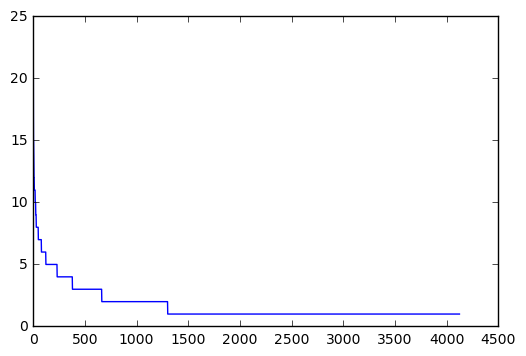

In [49]:
recordings = json.load(open('data/clean/recordings.json'))

works_rec_map = {}
for r in recordings:
    if r['work'] not in works_rec_map:
        works_rec_map[r['work']] = 0
    works_rec_map[r['work']] += 1
plt.plot(sorted(works_rec_map.values(), reverse=True))